# Decision Tree Experimentation
First, we import all relevant packages

The crossvalidation's train_test_split() help us by splitting data into train & test set. This is easy way out before we do further processing:
We should preprocess the data by partioning with the same percentage for training, cross_validation and test set.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn import tree
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

F:\Applications\Anaconda\envs\bt4240\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading dataset

Load Dataset and examine the initial features

In [2]:
# Input data before feature selection
input_data = pd.read_csv('processed_train.csv', index_col=0)

#Input data after feature selection
input_data_after_fs = pd.read_csv('processed_train_after_feature.csv', index_col=0)

In [3]:
print ("Dataset Length:: ", len(input_data))
print ("Dataset Shape: ", input_data.shape)
input_data.info()
input_data.head(5)

Dataset Length::  2973
Dataset Shape:  (2973, 217)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 2972
Columns: 217 entries, Id to age-range_
dtypes: bool(1), float64(13), int64(201), object(2)
memory usage: 4.9+ MB


,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_
0,ID_279628684,21eb7fcc1,4,0,0,1,1,1,0,0,...,10,10,10,0.000000,0,43,43,43,0.000000,0
1,ID_f29eb3ddd,0e5d7a658,4,0,0,1,1,0,0,0,...,12,12,12,0.000000,0,67,67,67,0.000000,0
2,ID_68de51c94,2c7317ea8,4,0,0,1,1,0,0,0,...,11,11,11,0.000000,0,92,92,92,0.000000,0
3,ID_ec05b1a7b,2b58d945f,4,0,0,1,1,1,0,0,...,2,11,33,4.272002,9,8,38,100,14.899664,30
4,ID_1284f8aad,d6dae86b7,4,1,0,1,1,1,0,0,...,0,11,23,5.123475,11,7,30,76,11.690452,23


As we are not doing any feature selection yet, we are gonna leave this section blank. 

In [4]:
#Split data into variables types - boolean, categorical, continuous, ID
bool_var = list(input_data.select_dtypes(['bool']))
cont_var = list(input_data.select_dtypes(['float64']))
cat_var = list(input_data.select_dtypes(['int64']))
id_var = list(input_data.select_dtypes(['object']))

#Get dataset with only categorical variables
cat_data = input_data[cat_var + bool_var]

#Get Continuous Variables from Data
cont_data = input_data[cont_var]

#Input Data can be from all except id details
final_input_data = input_data[cat_var + cont_var]

In [5]:
final_input_data['Target'].head(5)

0    4
1    4
2    4
3    4
4    4
Name: Target, dtype: int64

Creating X and Y variables. 
As shown above, target feature is at index 3 and the rest of the variables are the predictor variables. 

In [6]:
X = final_input_data.loc[:, final_input_data.columns != 'Target'].values
Y = final_input_data['Target'].values
Y=Y.astype('int')

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, 
                                                    random_state = 100 , stratify = Y)

## Using Dataset after Feature Selection

In [8]:
bool_var = list(input_data_after_fs.select_dtypes(['bool']))
cont_var = list(input_data_after_fs.select_dtypes(['float64']))
cat_var = list(input_data_after_fs.select_dtypes(['int64']))
id_var = list(input_data_after_fs.select_dtypes(['object']))

#Get dataset with only categorical variables
cat_data_fs = input_data_after_fs[cat_var + bool_var]

#Get Continuous Variables from Data
cont_data_fs = input_data_after_fs[cont_var]

#Input Data can be from all except id details
final_input_data_fs = input_data_after_fs[cat_var + cont_var]

In [9]:
X_fs = final_input_data_fs.loc[:, final_input_data_fs.columns != 'Target'].values
Y_fs = final_input_data_fs['Target'].values
Y_fs=Y_fs.astype('int')

In [10]:
X_train_fs, X_test_fs, Y_train_fs, Y_test_fs = train_test_split(X_fs, Y_fs, test_size = 0.25, 
                                                    random_state = 100 , stratify = Y_fs)

## Decision Tree Modelling

### Creating Baseline Decision Tree (Gini Index)

1. clf_gini: Cleaned Raw Dataset
2. clf_gini_fs: Cleaned Dataset after feature selection

In [11]:
clf_gini = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_gini.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [12]:
# Using dataset after feature selection
clf_gini_fs = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_gini_fs.fit(X_train_fs, Y_train_fs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

### Creating Baseline Decision Tree (Entropy)

Using Information Gain is the same as using entropy as criterion
1. clf_entropy: Cleaned Raw Dataset
2. clf_entropy_fs: Cleaned Dataset after feature selection

In [13]:
clf_entropy = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_entropy.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [14]:
# Using dataset after feature selection
clf_entropy_fs = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_entropy_fs.fit(X_train_fs, Y_train_fs)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

### Performance Metric For Dataset before Feature Selection
1. Accuracy Score
2. F1 Score
3. Confusion Matrix

In [15]:
# Predicting using Dataset before Feature Selection
Y_predict_entropy_initial = clf_entropy.predict(X_test)
Y_predict_gini_initial = clf_gini.predict(X_test)

In [16]:
# Assess predict score based on Accuracy Score for Dataset before Feature Selection

print ('Testing acc for entropy before feature selection is %f' %accuracy_score(Y_predict_entropy_initial, Y_test))
print ('Testing acc for gini before feature selection is %f' %accuracy_score(Y_predict_gini_initial, Y_test))

Testing acc for entropy before feature selection is 0.581989
Testing acc for gini before feature selection is 0.576613


In [17]:
# Assess predict score based on F1 Score for Dataset after Feature Selection

print ('Testing f1 score for entropy before feature selection is %f' %f1_score(Y_test, Y_predict_entropy_initial, labels=[1,2,3,4], average='weighted'))
print ('Testing f1 score for gini before feature selection is %f' %f1_score(Y_test, Y_predict_gini_initial, labels=[1,2,3,4], average='weighted'))

Testing f1 score for entropy before feature selection is 0.581394
Testing f1 score for gini before feature selection is 0.578491


In [18]:
# Assess predict score based on Confusion Matrix for Dataset after Feature Selection

print ('Testing confusion matrix for entropy before feature selection is \n', confusion_matrix(Y_test, Y_predict_entropy_initial, labels=[1,2,3,4]))
print ('Testing confusion matrix for gini before feature selection is \n', confusion_matrix(Y_test, Y_predict_gini_initial, labels=[1,2,3,4]))

Testing confusion matrix for entropy before feature selection is 
 [[ 14  15   5  21]
 [ 18  27  15  51]
 [  7  22  17  43]
 [ 22  49  43 375]]
Testing confusion matrix for gini before feature selection is 
 [[ 10  10   8  27]
 [ 14  32  20  45]
 [  7  24  17  41]
 [ 21  52  46 370]]


### Performance Metric For Dataset after Feature Selection
1. Accuracy Score
2. F1 Score
3. Confusion Matrix

In [19]:
# Predicting using Dataset after Feature Selection
Y_predict_entropy_initial_fs = clf_entropy_fs.predict(X_test_fs)
Y_predict_gini_initial_fs = clf_gini_fs.predict(X_test_fs)

In [20]:
# Assess predict score based on Accuracy Score for Dataset after Feature Selection

print ('Testing acc for entropy after feature selection is %f' %accuracy_score(Y_test_fs, Y_predict_entropy_initial_fs))
print ('Testing acc for gini after feature selection is %f' %accuracy_score(Y_predict_gini_initial_fs, Y_test_fs))

Testing acc for entropy after feature selection is 0.567204
Testing acc for gini after feature selection is 0.602151


In [21]:
# Assess predict score based on F1 Score for Dataset after Feature Selection

print ('Testing f1 score for entropy after feature selection is %f' %f1_score(Y_test_fs, Y_predict_entropy_initial_fs, labels=[1,2,3,4], average='weighted'))
print ('Testing f1 score for gini after feature selection is %f' %f1_score(Y_test_fs, Y_predict_gini_initial_fs, labels=[1,2,3,4], average='weighted'))

Testing f1 score for entropy after feature selection is 0.568924
Testing f1 score for gini after feature selection is 0.602241


In [22]:
# Assess predict score based on Confusion Matrix for Dataset after Feature Selection

print ('Testing confusion matrix for entropy after feature selection is \n', confusion_matrix(Y_test_fs, Y_predict_entropy_initial_fs, labels=[1,2,3,4]))
print ('Testing confusion matrix for gini after feature selection is \n', confusion_matrix(Y_test_fs, Y_predict_gini_initial_fs, labels=[1,2,3,4]))

Testing confusion matrix for entropy after feature selection is 
 [[  9  18   6  22]
 [ 12  29  19  51]
 [  8  22  16  43]
 [ 24  46  51 368]]
Testing confusion matrix for gini after feature selection is 
 [[ 13  12   6  24]
 [ 12  31  21  47]
 [  7  20  24  38]
 [ 17  43  49 380]]


### Initial Classification Results

In [23]:
# look at classification report for the initial modelling.
print ("Classification report for Gini: \n", classification_report(Y_test, Y_predict_gini_initial))
print ("Classification report for Entropy: \n", classification_report(Y_test, Y_predict_entropy_initial))

Classification report for Gini: 
              precision    recall  f1-score   support

          1       0.19      0.18      0.19        55
          2       0.27      0.29      0.28       111
          3       0.19      0.19      0.19        89
          4       0.77      0.76      0.76       489

avg / total       0.58      0.58      0.58       744

Classification report for Entropy: 
              precision    recall  f1-score   support

          1       0.23      0.25      0.24        55
          2       0.24      0.24      0.24       111
          3       0.21      0.19      0.20        89
          4       0.77      0.77      0.77       489

avg / total       0.58      0.58      0.58       744



## Other Metrics
Lets compute the cross-validation scores

In [24]:
scores = cross_val_score(clf_gini, X, Y, cv=5)
print("Accuracy for Gini: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_entropy, X, Y, cv=5)
print("Accuracy for InfoGain: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy for Gini: 0.50 (+/- 0.24)
Accuracy for InfoGain: 0.49 (+/- 0.24)


This shows that the cross validation stats are terrible. We should fix this.

## Graphing Parameters (Gini)

We are going to plot each parameters on a graph, based on accuracy score as the performance metric. 

In [25]:
# I am doing this here cos I lazy
X_test = X_test_fs
Y_test = Y_test_fs
X_train = X_train_fs
Y_train = Y_train_fs

### Max Depth

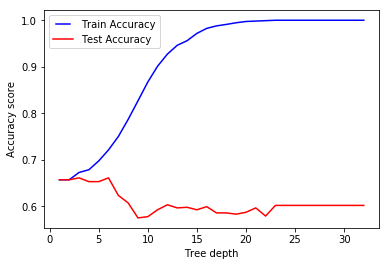

Best Max Depth Value: 3.0
Corresponding Accuracy Value: 0.6612903225806451


In [26]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=max_depth,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(max_depths, train_results,'b', label="Train Accuracy")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("Tree depth")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_max_depth = max_depths[test_results.index(best_accuracy_score)]
print ('Best Max Depth Value:', best_max_depth)
print ('Corresponding Accuracy Value:', best_accuracy_score)

### Min Sample Split

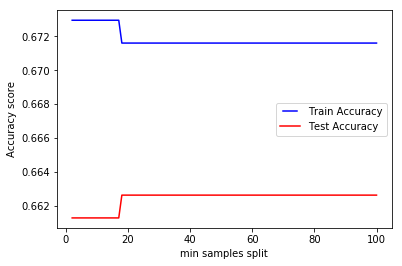

Best Min Sample Split Value: 18.0
Corresponding Accuracy Value: 0.6626344086021505


In [27]:
min_samples_splits = np.linspace(2, 100, 99, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=int(min_samples_split), min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(min_samples_splits, train_results,'b', label="Train Accuracy")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("min samples split")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_min_samples_split = min_samples_splits[test_results.index(best_accuracy_score)]
print ('Best Min Sample Split Value:', best_min_samples_split)
print ('Corresponding Accuracy Value:', best_accuracy_score)

### Min Samples Leaf

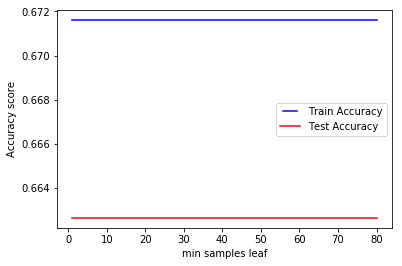

Best Min Samples Leaf Value: 1.0
Corresponding Accuracy Value: 0.6626344086021505


In [28]:
min_samples_leafs = np.linspace(1, 80, 80, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=int(min_samples_leaf),
                                     min_samples_split=18, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(min_samples_leafs, train_results,'b', label="Train Accuracy")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("min samples leaf")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_min_samples_leaf = min_samples_leafs[test_results.index(best_accuracy_score)]
print ('Best Min Samples Leaf Value:', best_min_samples_leaf)
print ('Corresponding Accuracy Value:', best_accuracy_score)

### Max Features

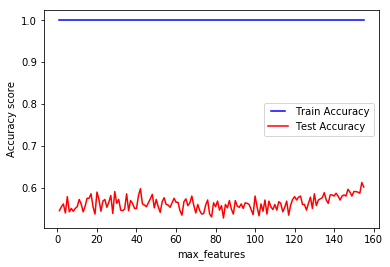

Best Max Feature Value: 154
Corresponding Accuracy Value: 0.6129032258064516


In [29]:
max_features = list(range(1,final_input_data_fs.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                                     max_features=max_feature, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(max_features, train_results,'b', label="Train Accuracy")
line2, = plt.plot(max_features, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("max_features")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_max_feature = max_features[test_results.index(best_accuracy_score)]
print ('Best Max Feature Value:', best_max_feature)
print ('Corresponding Accuracy Value:', best_accuracy_score)

## Graphing Parameters (Entropy)

We are going to plot each parameters on a graph, based on accuracy score as the performance metric. 

### Max Depth

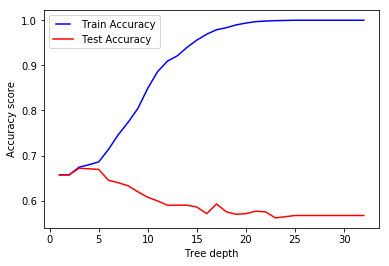

Best Max Depth Value: 3.0
Corresponding Accuracy Value: 0.6720430107526881


In [30]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=max_depth,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(max_depths, train_results,'b', label="Train Accuracy")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("Tree depth")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_max_depth = max_depths[test_results.index(best_accuracy_score)]
print ('Best Max Depth Value:', best_max_depth)
print ('Corresponding Accuracy Value:', best_accuracy_score)

### Min Sample Split

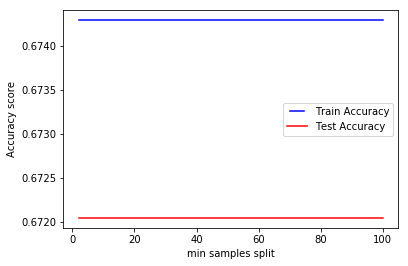

Best Min Sample Split Value: 2.0
Corresponding Accuracy Value: 0.6720430107526881


In [31]:
min_samples_splits = np.linspace(2, 100, 99, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=int(min_samples_split), min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(min_samples_splits, train_results,'b', label="Train Accuracy")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("min samples split")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_min_samples_split = min_samples_splits[test_results.index(best_accuracy_score)]
print ('Best Min Sample Split Value:', best_min_samples_split)
print ('Corresponding Accuracy Value:', best_accuracy_score)

### Min Samples Leaf

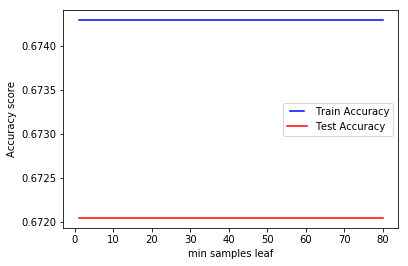

Best Min Samples Leaf Value: 1.0
Corresponding Accuracy Value: 0.6720430107526881


In [32]:
min_samples_leafs = np.linspace(1, 80, 80, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=int(min_samples_leaf),
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(min_samples_leafs, train_results,'b', label="Train Accuracy")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("min samples leaf")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_min_samples_leaf = min_samples_leafs[test_results.index(best_accuracy_score)]
print ('Best Min Samples Leaf Value:', best_min_samples_leaf)
print ('Corresponding Accuracy Value:', best_accuracy_score)

### Max Features

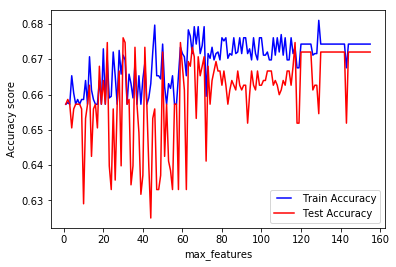

Best Max Feature Value: 30
Corresponding Accuracy Value: 0.6760752688172043


In [33]:
max_features = list(range(1,final_input_data_fs.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                                     max_features=max_feature, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=1,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
    dt.fit(X_train, Y_train)
    train_pred = dt.predict(X_train)
    accuracy_train = accuracy_score(Y_train, train_pred)
    # Add acc score to previous train results
    train_results.append(accuracy_train)
    y_pred = dt.predict(X_test)
    accuracy_test = accuracy_score(Y_test, y_pred)
    # Add acc score to previous test results
    test_results.append(accuracy_test)

line1, = plt.plot(max_features, train_results,'b', label="Train Accuracy")
line2, = plt.plot(max_features, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("max_features")
plt.show()

# Finding the best score and parameter to use

best_accuracy_score = max(test_results)
best_max_feature = max_features[test_results.index(best_accuracy_score)]
print ('Best Max Feature Value:', best_max_feature)
print ('Corresponding Accuracy Value:', best_accuracy_score)

# Final Tuning of Parameters
Lets try combining them together first

In [34]:
clf_gini = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
                                     max_features=154, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=50,
                                     min_samples_split=79, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_gini.fit(X_train_fs, Y_train_fs)

clf_entropy = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3.0,
                                     max_features=57, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=47,
                                     min_samples_split=89, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_entropy.fit(X_train_fs, Y_train_fs)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3.0,
            max_features=57, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=47, min_samples_split=89,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [35]:
# predict( ) will do the model prediction, predict y based on the input x
Y_predict_gini = clf_gini.predict(X_test)
print ('testing acc for gini is %f' %accuracy_score(Y_predict_gini, Y_test))
Y_predict_entropy = clf_entropy.predict(X_test)
print ('testing acc for entropy is %f' %accuracy_score(Y_predict_entropy, Y_test))

testing acc for gini is 0.662634
testing acc for entropy is 0.657258


This obviously didn't work. Lets try to use what was the highest in the model instead.

In [43]:
clf_gini = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=50,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_gini.fit(X_train, Y_train)

clf_entropy = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_split=1e-07, min_samples_leaf=52,
                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                                     presort=False, random_state=100, splitter='best')
clf_entropy.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=52,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [44]:
# predict( ) will do the model prediction, predict y based on the input x
Y_predict_gini = clf_gini.predict(X_test)
print ('testing acc for gini is %f' %accuracy_score(Y_predict_gini, Y_test))
Y_predict_entropy = clf_entropy.predict(X_test)
print ('testing acc for entropy is %f' %accuracy_score(Y_predict_entropy, Y_test))

testing acc for gini is 0.676075
testing acc for entropy is 0.669355


In [45]:
# predict( ) will do the model prediction, predict y based on the input x
print ('testing f1 score for Gini after feature selection is %f' %f1_score(Y_test_fs, Y_predict_gini, labels=[1,2,3,4], average='weighted'))
print ('testing f1 score for Entropy after feature selection is %f' %f1_score(Y_test_fs, Y_predict_entropy, labels=[1,2,3,4], average='weighted'))

testing f1 score for Gini after feature selection is 0.602791
testing f1 score for Entropy after feature selection is 0.606306


F:\Applications\Anaconda\envs\bt4240\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
# look at classification report for the above tuning.
print ("Classification report for Gini: \n", classification_report(Y_test_fs, Y_predict_gini))

Classification report for Gini: 
              precision    recall  f1-score   support

          1       0.39      0.16      0.23        55
          2       0.39      0.27      0.32       111
          3       0.00      0.00      0.00        89
          4       0.72      0.95      0.82       489

avg / total       0.56      0.68      0.60       744



F:\Applications\Anaconda\envs\bt4240\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
# Assess predict score based on Confusion Matrix for Dataset after Feature Selection

print ('Testing confusion matrix for entropy after feature selection is \n', confusion_matrix(Y_test_fs, Y_predict_gini, labels=[1,2,3,4]))

Testing confusion matrix for entropy after feature selection is 
 [[  9  11   0  35]
 [  5  30   0  76]
 [  3  16   0  70]
 [  6  19   0 464]]


In [40]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [41]:
dot_data = StringIO()
export_graphviz(clf_gini, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found